In [1]:
# imports
import yaml
from typing import List, Dict, Tuple, TypeVar, Any
import numpy as np
from numpy.typing import NDArray
from queue import Queue
import matplotlib.pyplot as plt

In [2]:
# Enter world here
with open('worlds.yml', 'r') as f:
  worlds = yaml.safe_load(f)

world = worlds['world_1']

grid_2d = np.array(world['grid'])
grid = grid_2d[np.newaxis, :, :]

agent_start = np.array(world['agent_start'])[0]

grid = np.repeat(grid, 8, axis=0)

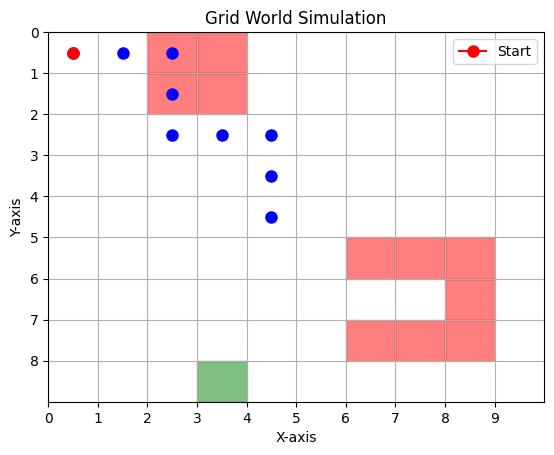

In [3]:
# simulation
grid_height = grid.shape[1]
grid_width = grid.shape[2]
agent_position = agent_start

#TODO update outside instead of using dummy
agent_trajectory = [
    (0, 0), (1, 0), (2, 0), (2, 1), (2, 2), (3, 2), (4, 2), (4, 3), (4, 4)
]
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the grid
for y in range(grid_height):
    for x in range(grid_width):
        if grid_2d[y, x] == 0:
            color = 'white'
        elif grid_2d[y, x] == 1:
            color = 'red'
        else:
            color = 'green'
        rect = plt.Rectangle((x, y), 1, 1, color=color, alpha=0.5)
        ax.add_patch(rect)


# Plot the agent's trajectory
for pos in agent_trajectory:
    ax.plot(pos[0] + 0.5, pos[1] + 0.5, marker='o', markersize=8, color='blue')

# Plot the agent's initial position
ax.plot(agent_position[0] + 0.5, agent_position[1] + 0.5, marker='o', markersize=8, color='red', label='Start')

# Set plot attributes
plt.title('Grid World Simulation')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.xlim(0, grid_width)
plt.ylim(0, grid_height)
plt.xticks(range(0, grid_width, 1))
plt.yticks(range(0, grid_height, 1)) 
plt.gca().invert_yaxis()  
plt.grid(visible=True)
plt.legend()

# Show the plot
plt.show()


In [18]:
# Handle everything related to graph search
class Node:
    def __init__(self, theta: int, y: int, x: int):
        self.x = x
        self.y = y
        self.theta = theta
        self.visible = False
        self.obstructed = False
        self.in_gf = False
        self.in_gb = False
        self.gf_parent = None
        self.gf_children = []
        self.gb_parent = None
        self.gb_children = []

    def __eq__(self, other: 'Node'):
        return self.x == other.x and self.y == other.y and self.theta == other.theta
    
    def __hash__(self):
        return hash((self.x, self.y, self.theta))


    # gets the children when searching for connection to GF. This means that 
    # these 'children' are actually potential parents, and are gotten using the
    # inverse dynamics
    def get_bfs_children(self, this_world: NDArray=world, 
                         this_grid_width=grid_width, 
                         this_grid_height=grid_height) -> List['Node']:
        
        children = []
        # ugly workaround to get the x-y coordinates of the potential parents
        child_x = self.x
        child_y = self.y
        if self.theta == 0:
            child_y += 1
        if self.theta == 1:
            child_x -= 1
            child_y += 1
        if self.theta == 2:
            child_x -= 1
        if self.theta == 3:
            child_x -= 1
            child_y -= 1
        if self.theta == 4:
            child_y -= 1
        if self.theta == 5:
            child_x += 1
            child_y -= 1
        if self.theta == 6:
            child_x += 1
        if self.theta == 7:
            child_x += 1
            child_y += 1

        # check if the potential parent is not in the world
        if    (child_x < 0 or child_x >= this_grid_width 
            or child_y < 0 or child_y >= this_grid_height):
            return children

        for i in range(self.theta - 1, self.theta + 2):
            theta_index = i % 8
            children.append(this_world[theta_index, child_y, child_x])
        return children

# BFS to connect to GF
# returns: the node that is connected to GF, or None if no connection is found
def connect_to_gf_bfs(start: Node, goal_set: List[Node], this_world=world, this_grid=grid_2d) -> Node:
    assert start.bfs_parent is None, 'Start node should not have a bfs_parent'
    start.bfs_parent = None

    parents_dict = {}
    parents_dict[start] = None
    q = Queue()
    q.put(start)
    curr_node = None
    iteration = 0
    while not q.empty():
        curr_node = q.get()
        print('='*20)
        print(f'Iteration {iteration}')
        print(f'curr_node tyx: {curr_node.theta}, {curr_node.y}, {curr_node.x}')
        iteration += 1
        assert type(curr_node) == Node
        if curr_node in goal_set or curr_node.in_gf:
            break
        children = curr_node.get_bfs_children(this_world, 
                                              this_grid_width=this_grid.shape[1], 
                                              this_grid_height=this_grid.shape[0])
        for child in children:
            # TODO:change logic to use grid_2d
            # grid_2d[child.y, child.x] == 0 means unobstructed
            # grid_2d[child.y, child.x] == 1 means obstructed
            if child.visible and not child.obstructed and not child in parents_dict:
                # child.bfs_parent = curr_node
                parents_dict[child] = curr_node
                q.put(child)
                print(f'\tChild added: {child.theta}, {child.y}, {child.x}')

    if curr_node is None or not curr_node.in_gf:
        # print('No connection to GF found')
        return None
    winner = curr_node
    # backtrack to connect GF
    while curr_node in parents_dict:
        curr_node.in_gf = True
        next_node = parents_dict[curr_node]
        if next_node is None:
            break
        curr_node.gf_children.append(next_node)
        next_node.gf_parent = curr_node
        print(f'Just marked this node in GF: {curr_node.theta}, {curr_node.y}, {curr_node.x}')
        curr_node = next_node
    return winner

    # BFS to connect to GB


# Test the get_bfs_children function, world is a 3D array: theta, y, x
def test_get_bfs_children():
    world = np.zeros((8, 5, 5), dtype=Node)
    for i in range(5):
        for j in range(5):
            for k in range(8):
                world[k, i, j] = Node(k, i, j)
    start = world[0, 0, 0]
    children = start.get_bfs_children(world)
    assert len(children) == 3
    assert children[0] == world[7, 1, 0]
    assert children[1] == world[0, 1, 0]
    assert children[2] == world[1, 1, 0]

    start = world[3, 0, 0]
    children = start.get_bfs_children(world)
    assert len(children) == 0

    start = world[2, 0, 1]
    children = start.get_bfs_children(world)
    assert len(children) == 3
    assert children[0] == world[1, 0, 0]
    assert children[1] == world[2, 0, 0]
    assert children[2] == world[3, 0, 0]

def test_connect_to_gf_bfs():
    world = np.zeros((8, 5, 5), dtype=Node)
    this_grid = np.zeros((5, 5))
    for i in range(5):
        for j in range(5):
            for k in range(8):
                world[k, i, j] = Node(k, i, j)
                world[k, i, j].visible = True
    start = world[0, 0, 0]
    goal_to_find = world[0, 2, 0]
    goal_to_find.in_gf = True
    goal_set = [goal_to_find]
    goal = connect_to_gf_bfs(start, goal_set, world, this_grid)
    assert goal == goal_to_find
    assert start.gf_parent == world[0, 1, 0]
    assert start.gf_parent.gf_parent == world[0, 2, 0]
    assert start.in_gf == True

    start = world[7, 0, 0]
    goal_to_find = world[0, 2, 1]
    goal_to_find.in_gf = True
    goal_set = [goal_to_find]
    goal = connect_to_gf_bfs(start, goal_set, world, this_grid)
    assert goal == goal_to_find
    assert start.gf_parent == world[0, 1, 1]
    assert start.gf_parent.gf_parent == world[0, 2, 1]
    assert start.in_gf == True


    start = world[0, 4, 4]
    goal_to_find = world[7, 2, 0]
    goal_to_find.in_gf = True
    goal_set = [goal_to_find]
    goal = connect_to_gf_bfs(start, goal_set, world, this_grid)
    assert goal == None


test_get_bfs_children()
test_connect_to_gf_bfs()

Iteration 0
curr_node tyx: 0, 0, 0
	Child added: 7, 1, 0
	Child added: 0, 1, 0
	Child added: 1, 1, 0
Iteration 1
curr_node tyx: 7, 1, 0
	Child added: 6, 2, 1
	Child added: 7, 2, 1
	Child added: 0, 2, 1
Iteration 2
curr_node tyx: 0, 1, 0
	Child added: 7, 2, 0
	Child added: 0, 2, 0
	Child added: 1, 2, 0
Iteration 3
curr_node tyx: 1, 1, 0
Iteration 4
curr_node tyx: 6, 2, 1
	Child added: 5, 2, 2
	Child added: 6, 2, 2
	Child added: 7, 2, 2
Iteration 5
curr_node tyx: 7, 2, 1
	Child added: 6, 3, 2
	Child added: 7, 3, 2
	Child added: 0, 3, 2
Iteration 6
curr_node tyx: 0, 2, 1
	Child added: 7, 3, 1
	Child added: 0, 3, 1
	Child added: 1, 3, 1
Iteration 7
curr_node tyx: 7, 2, 0
	Child added: 6, 3, 1
Iteration 8
curr_node tyx: 0, 2, 0
Just marked this node in GF: 0, 2, 0
Just marked this node in GF: 0, 1, 0
Iteration 0
curr_node tyx: 7, 0, 0
	Child added: 6, 1, 1
	Child added: 7, 1, 1
	Child added: 0, 1, 1
Iteration 1
curr_node tyx: 6, 1, 1
	Child added: 5, 1, 2
	Child added: 6, 1, 2
	Child added: